In [1]:
from typing import Sequence

import numpy as np
import jax
import jax.numpy as jnp
import flax.linen as nn
import matplotlib.pyplot as plt
jax.config.update("jax_enable_x64", True)

class MLP(nn.Module):
  features: Sequence[int]
  in_MinMax: np.array
  out_MinMax: np.array
  NN_params: dict

  @nn.compact
  def __call__(self, x):
    for feat in self.features[:-1]:
      x = nn.tanh(nn.Dense(feat)(x))
    x = nn.Dense(self.features[-1])(x)
    return x

  def maximin_input(self, input):
    return (input - self.in_MinMax[:,0]) / (self.in_MinMax[:,1] - self.in_MinMax[:,0])

  def inv_maximin_output(self, output):
    return output * (self.out_MinMax[:,1] - self.out_MinMax[:,0]) + self.out_MinMax[:,0]
        
  def get_Cl(self, input):
    norm_input = self.maximin_input(input)
    norm_model_output = self.apply(self.NN_params, norm_input)
    model_output = self.inv_maximin_output(norm_model_output)*np.exp(input[0]-3.)
    #here we are also postprocessing the Cls, according to what was done in Cpase release paper
    return model_output

In [2]:
def load_weights(weights):
    layer_0_weights = weights[0:64*6].reshape(6,64)
    layer_0_bias = weights[64*6:64*6+64]
    layer_1_weights = weights[64*6+64:64*6+64+64*64].reshape(64,64)
    layer_1_bias = weights[64*6+64+64*64:64*6+64+64*64+64]
    layer_2_weights = weights[64*6+64+64*64+64:64*6+64+64*64+64+64*64].reshape(64,64)
    layer_2_bias = weights[64*6+64+64*64+64+64*64:64*6+64+64*64+64+64*64+64]
    layer_3_weights = weights[64*6+64+64*64+64+64*64+64:64*6+64+64*64+64+64*64+64+64*64].reshape(64,64)
    layer_3_bias = weights[64*6+64+64*64+64+64*64+64+64*64:64*6+64+64*64+64+64*64+64+64*64+64]
    layer_4_weights = weights[64*6+64+64*64+64+64*64+64+64*64+64:64*6+64+64*64+64+64*64+64+64*64+64+64*64].reshape(64,64)
    layer_4_bias = weights[64*6+64+64*64+64+64*64+64+64*64+64+64*64:64*6+64+64*64+64+64*64+64+64*64+64+64*64+64]
    layer_5_weights = weights[64*6+64+64*64+64+64*64+64+64*64+64+64*64+64:64*6+64+64*64+64+64*64+64+64*64+64+64*64+64+64*4999].reshape(64,4999)
    layer_5_bias = weights[64*6+64+64*64+64+64*64+64+64*64+64+64*64+64+64*4999:64*6+64+64*64+64+64*64+64+64*64+64+64*64+64+64*4999+4999]

    variables= dict()
    variables['params'] = {}
    variables['params']['Dense_0'] = {}
    variables['params']['Dense_1'] = {}
    variables['params']['Dense_2'] = {}
    variables['params']['Dense_3'] = {}
    variables['params']['Dense_4'] = {}
    variables['params']['Dense_5'] = {}

    variables['params']['Dense_0']['kernel'] = layer_0_weights
    variables['params']['Dense_0']['bias']   = layer_0_bias
    variables['params']['Dense_1']['kernel'] = layer_1_weights
    variables['params']['Dense_1']['bias']   = layer_1_bias
    variables['params']['Dense_2']['kernel'] = layer_2_weights
    variables['params']['Dense_2']['bias']   = layer_2_bias
    variables['params']['Dense_3']['kernel'] = layer_3_weights
    variables['params']['Dense_3']['bias']   = layer_3_bias
    variables['params']['Dense_4']['kernel'] = layer_4_weights
    variables['params']['Dense_4']['bias']   = layer_4_bias
    variables['params']['Dense_5']['kernel'] = layer_5_weights
    variables['params']['Dense_5']['bias']   = layer_5_bias

    return variables


In [3]:
#loading weights
in_MinMax = jnp.load("inMinMax_lcdm.npy")

capse_weights_TT = jnp.load("weights_TT_lcdm.npy")
out_MinMax_TT = jnp.load("outMinMaxCℓTT_lcdm.npy")
variables_TT = load_weights(capse_weights_TT)

capse_weights_EE = jnp.load("weights_EE_lcdm.npy")
out_MinMax_EE = jnp.load("outMinMaxCℓEE_lcdm.npy")
variables_EE = load_weights(capse_weights_EE)

capse_weights_TE = jnp.load("weights_TE_lcdm.npy")
out_MinMax_TE = jnp.load("outMinMaxCℓTE_lcdm.npy")
variables_TE = load_weights(capse_weights_TE)

capse_weights_PP = jnp.load("weights_PP_lcdm.npy")
out_MinMax_PP = jnp.load("outMinMaxCℓPP_lcdm.npy")
variables_PP = load_weights(capse_weights_PP)

In [4]:
#instantiating MLP with correct architecture
Capse_TT = MLP([64, 64, 64, 64, 64, 4999], in_MinMax, out_MinMax_TT, variables_TT)
Capse_EE = MLP([64, 64, 64, 64, 64, 4999], in_MinMax, out_MinMax_EE, variables_EE)
Capse_TE = MLP([64, 64, 64, 64, 64, 4999], in_MinMax, out_MinMax_TE, variables_TE)
Capse_PP = MLP([64, 64, 64, 64, 64, 4999], in_MinMax, out_MinMax_PP, variables_PP)

In [5]:
#|model = MLP(features, in_MinMax, out_MinMax, NN_params)
input_test = np.array([3, 0.96, 67, 0.02, 0.12, 0.05])  # replace with your input
Cl = Capse_TT.get_Cl(input_test)

In [6]:
%timeit Capse_TT.get_Cl(input_test)

12.6 ms ± 442 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


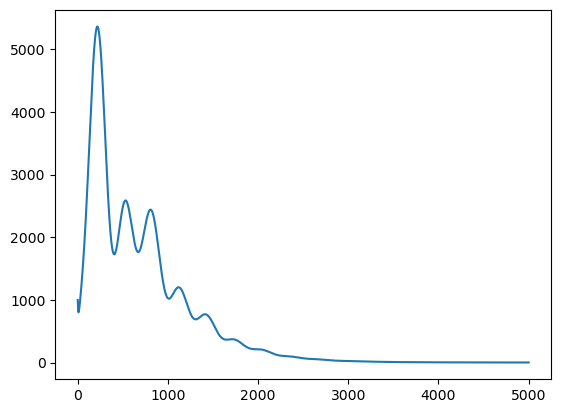

In [7]:
l = jnp.arange(2, 5000+1)
plt.plot(l, Capse_TT.get_Cl(input_test))

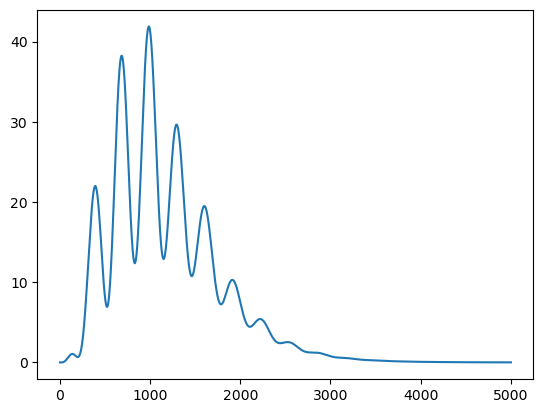

In [8]:
plt.plot(l, Capse_EE.get_Cl(input_test))

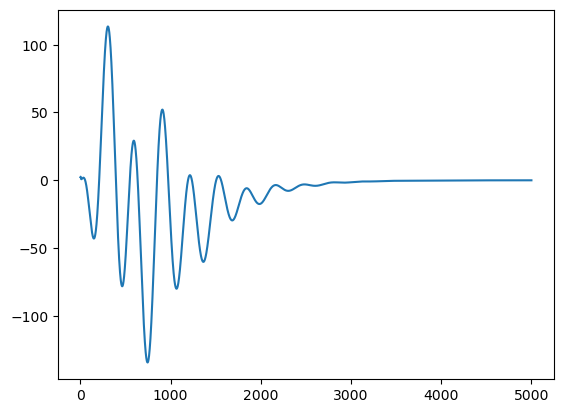

In [9]:
plt.plot(l, Capse_TE.get_Cl(input_test))

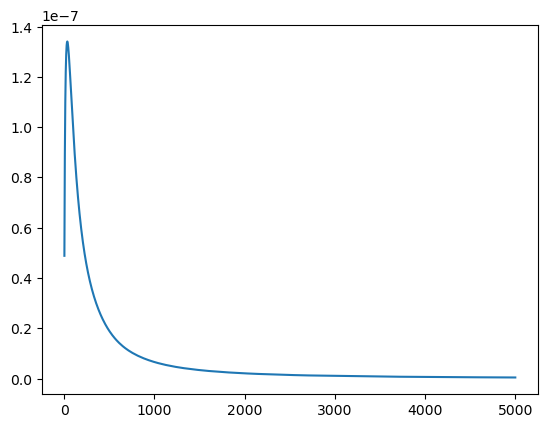

In [10]:
plt.plot(l, Capse_PP.get_Cl(input_test))